# Requirements of the Project

In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece
!pip install transformers
!pip install torch
!pip install nltk

     |████████████████████████████████| 51kB 6.1MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.7-cp36-none-any.whl size=30539 sha256=a8bff8a1fd2da28f71fd342ddaf7a7453dd23925e84f30d144d235723d870caa
  Stored in directory: /root/.cache/pip/wheels/e1/f8/e2/b98f79a6b8cc898d8e4102b83acb8a098df7d27500a2bac912
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=8573f1298c4ceca97e3448addacbd89efebfabd7f84d6401516ca07ddcb9b0fb
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=c9903e3c18be0845bdcfd52e8113214a1b9af0854ac96da393f66fae69314236
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.1MB 10.5MB/s 
     |████████████████████████████

In [ ]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers


In [ ]:
import pandas as pd
import numpy as np
import bert
import re
import torch
from transformers import BertModel ,BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, BertForMultipleChoice
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup
import tensorflow as tf
from collections import defaultdict
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [ ]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


# 1. Reading the Data



##### 1.1 Reading the dataset and converting it to the DataFrame using Pandas


In [ ]:
dataframe = pd.read_csv('Tweets.csv') 
dataframe.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


#### 1.2 Dropping the unnecessary columns


Text(0.5, 0, 'Dataset Sentiment Result Distribution')

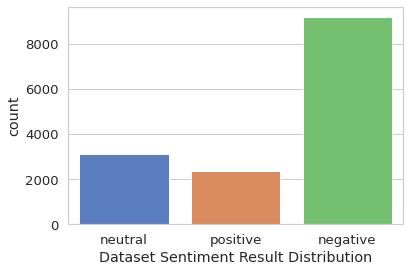

In [ ]:
sns.countplot(dataframe.airline_sentiment)
plt.xlabel('Dataset Sentiment Result Distribution')

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

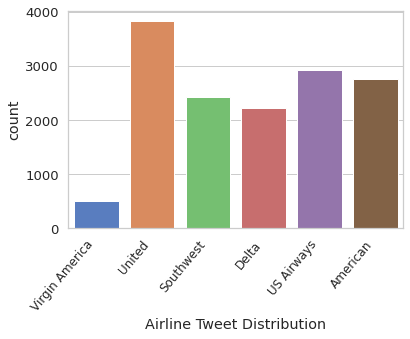

In [ ]:
ax = sns.countplot(dataframe.airline)
plt.xlabel("Airline Tweet Distribution")

plt.xticks(
    rotation=50, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'  
)

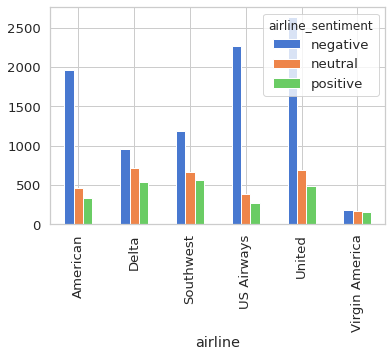

In [ ]:
airline_sentiment = dataframe.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

In [ ]:
dataframe = dataframe.drop(["airline_sentiment_confidence", "negativereason", "negativereason_confidence", "airline", "airline_sentiment_gold",
               "name", "negativereason_gold", "retweet_count", "tweet_coord", "tweet_created", "tweet_location", "user_timezone"], axis=1)

#### 1.3 Creating the function for pre-processing the "text" column of the dataframe


In [ ]:
def preprocess(text):
  #text = text.lower() #make it lowercase
  text = re.sub(r'@[A-Za-z0-9]+','',text) #remove @mentions
  text = re.sub(r'#','',text) #remove hashtags
  text = re.sub(r'RT[\s]+','',text) #remove RT
  text = re.sub(r"http\S+", "", text)  #remove hyperlinks
  text = re.sub(r'&amp;', '&', text)

  return text

### 1.4 Applying pre-process function the the whole "text" column and creating a new column named "cleaned_text"


In [ ]:
dataframe['cleaned_text'] = dataframe.text.apply(preprocess)

In [ ]:
dataframe['cleaned_text']

0                                              What  said.
1         plus you've added commercials to the experien...
2         I didn't today... Must mean I need to take an...
3         it's really aggressive to blast obnoxious "en...
4                 and it's a really big bad thing about it
                               ...                        
14635     thank you we got on a different flight to Chi...
14636     leaving over 20 minutes Late Flight. No warni...
14637       Please bring American Airlines to BlackBerry10
14638     you have my money, you change my flight, and ...
14639     we have 8 ppl so we need 2 know how many seat...
Name: cleaned_text, Length: 14640, dtype: object

In [ ]:
#dataframe['cleaned_text'] = dataframe['cleaned_text'] .map(lambda x: ' '.join([word for word in x.split(' ') if word not in stop_words]))


In [ ]:
#dataframe['cleaned_text']

## 1.5 Changing the sentiments to the numbers


In [ ]:
dataframe['airline_sentiment'] = dataframe.airline_sentiment.replace("neutral",1)
dataframe['airline_sentiment'] = dataframe.airline_sentiment.replace("negative", 0)
dataframe['airline_sentiment'] = dataframe.airline_sentiment.replace("positive",2)
dataframe['airline_sentiment'].unique()

array([1, 2, 0])

# 2. Training, Validation and Test Set

## 2.1 Splitting the whole dataset into Training, Validation and Test set

In [ ]:
RANDOM_SEED = 42
dataframe_train, dataframe_test = train_test_split(dataframe, test_size = 0.4, random_state = RANDOM_SEED)
dataframe_validation, dataframe_test = train_test_split(dataframe_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
dataframe_train.shape, dataframe_validation.shape, dataframe_test.shape

((8784, 4), (2928, 4), (2928, 4))

## 2.2 Getting the values of the datasets in order to use them in the DataLoader

In [ ]:
training_sentences = dataframe_train.cleaned_text.values
training_sentiments = dataframe_train.airline_sentiment.values

validation_sentences = dataframe_validation.cleaned_text.values
validation_sentiments = dataframe_validation.airline_sentiment.values

test_sentences = dataframe_test.cleaned_text.values
test_sentiments = dataframe_test.airline_sentiment.values

# 3. Modelling

## 3.1 Creating the BertTokenizer

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

## 3.2 Defining the Parameters

In [ ]:
BATCH_SIZE = 16
MAX_LEN = 64
LEARNING_RATE = 2e-5
EPOCHS = 8

## 3.3 Creating Dataset Class

In [ ]:
class Sentiment_Analysis_Model(Dataset):

  def __init__(self, tweets, sentiments, tokenizer, max_len):

    self.tweets = tweets
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.tweets)

  def __getitem__(self, item):
    tweet = str(self.tweets[item])
    sentiment = self.sentiments[item]

    encoding = self.tokenizer.encode_plus(
      tweet,
      add_special_tokens=True,
      max_length= self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation = True,
      return_tensors='pt',
    )

    return {
        "tweet" : tweet,
        "input_ids" : encoding['input_ids'].flatten(),
        "attention_mask" : encoding['attention_mask'].flatten(),
        "sentiment" : torch.tensor(sentiment, dtype=torch.long)
    }

## 3.4 Creating objects using Sentiments Analysis Model

In [ ]:
train_dataset = Sentiment_Analysis_Model(training_sentences,training_sentiments,tokenizer,MAX_LEN)
validation_dataset = Sentiment_Analysis_Model(validation_sentences,validation_sentiments,tokenizer,MAX_LEN)
test_dataset = Sentiment_Analysis_Model(test_sentences,test_sentiments,tokenizer, MAX_LEN)

## 3.5 Creating DataLoaders using Sentiments Analysis Model objects

In [ ]:
train_dataLoader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, num_workers=4, shuffle=True)
validation_dataLoader = DataLoader(dataset = validation_dataset, batch_size = BATCH_SIZE, num_workers=4,shuffle=True)
test_dataLoader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, num_workers=4, shuffle=True)

## 3.6 Creating the BertForSequenceClassification Model

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased", # Use the 12-layer BERT model, with an cased vocab.
    num_labels = 3, # The number of output labels
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    hidden_dropout_prob = 0.5 #default drop out probability was 0.1, changed it to 0.5
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
model.dropout

Dropout(p=0.5, inplace=False)

## 3.7 Using the model with GPU

In [ ]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

## 3.8 Creating the Adam Optimizer

In [ ]:
adam_optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5,
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

## 3.9 Creating the Scheduler

In [ ]:
total_steps = len(train_dataLoader) * EPOCHS

In [ ]:
scheduler = get_linear_schedule_with_warmup(
  adam_optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

# 4. Training, Validation and Testing 

## 4.1 Loss Function

In [ ]:
loss_function = nn.CrossEntropyLoss().to(device)

In [ ]:
import random

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)


## 4.2 Training function for one epoch

In [ ]:
def train_model_one_epoch(model, data_loader, optimizer, scheduler, device, n_examples):

  model.train()
  
  losses = []
  correct_predictions = 0

  for data in data_loader:

    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    sentiments = data['sentiment'].to(device)

    adam_optimizer.zero_grad() #clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).

    # Perform a forward pass (evaluate the model on this training batch).
    outputs = model(input_ids = input_ids, 
                    attention_mask = attention_mask,
                    labels = sentiments 
                    )
    

    # The call to `model` always returns a tuple, so we need to pull the 
    # predictions value out of the tuple.
    predictions = outputs[1]
    _, preds = torch.max(predictions, dim=1)
    
    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple.
    loss = outputs[0]
    
    correct_predictions += torch.sum(preds == sentiments)
    losses.append(loss.item())

    # Perform a backward pass to calculate the gradients.
    loss.backward() 

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    adam_optimizer.step()

    # Update the learning rate.
    scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

## 4.3 Validation functioon

In [ ]:
def eval_model(model, data_loader, device, n_examples):
  
  model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for data in data_loader:

      input_ids = data['input_ids'].to(device)
      attention_mask = data['attention_mask'].to(device)
      sentiments = data['sentiment'].to(device)

      # Forward pass, calculate predictions.
      # This will return the predictions rather than the loss because we have
      # not provided labels.
      outputs = model(input_ids = input_ids, 
                        attention_mask = attention_mask
                        ) 
      
      predictions = outputs[0]
      _, preds = torch.max(predictions, dim=1)

      loss = loss_function(predictions, sentiments)

      correct_predictions += torch.sum(preds == sentiments)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

## 4.4 Training and Validation Part

In [ ]:
total_loss = []
history = defaultdict(list)
best_accuracy = 0


for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  print('Training...')

  train_acc, train_loss = train_model_one_epoch(
    model = model,
    data_loader = train_dataLoader,    
    optimizer = adam_optimizer,
    scheduler = scheduler, 
    device = device, 
    n_examples = len(dataframe_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    validation_dataLoader,
    device, 
    len(dataframe_validation)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

  
print("")
print("Training complete!")

Epoch 1/8
----------
Training...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.7619653258384468 accuracy 0.6865892531876139


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5941616454736782 accuracy 0.7711748633879781

Epoch 2/8
----------
Training...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.5852226031933977 accuracy 0.768556466302368


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5089308079637465 accuracy 0.798155737704918

Epoch 3/8
----------
Training...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.528675221897431 accuracy 0.7889344262295082


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.5151170436801806 accuracy 0.8056693989071039

Epoch 4/8
----------
Training...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.49050404048628277 accuracy 0.805327868852459


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.45552678650519884 accuracy 0.8224043715846995

Epoch 5/8
----------
Training...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.4632247015426719 accuracy 0.8201275045537341


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.4709039026759361 accuracy 0.8210382513661202

Epoch 6/8
----------
Training...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.4393610904342707 accuracy 0.8335610200364298


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.4715318254047567 accuracy 0.8271857923497268

Epoch 7/8
----------
Training...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.4334484300625346 accuracy 0.829804189435337


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.45506525670732956 accuracy 0.826844262295082

Epoch 8/8
----------
Training...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Train loss 0.4190691851880164 accuracy 0.8397085610200364


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Val   loss 0.45902187230645636 accuracy 0.828551912568306


Training complete!


In [ ]:
model.save_pretrained('/content')

## 4.5 Plot of Training and Validation Accuracy

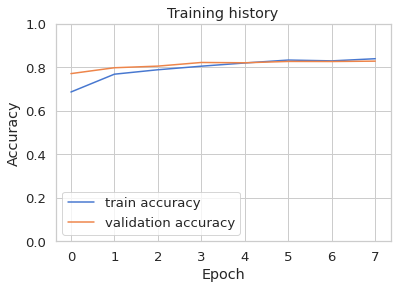

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## 4.6 Plot of Training Loss

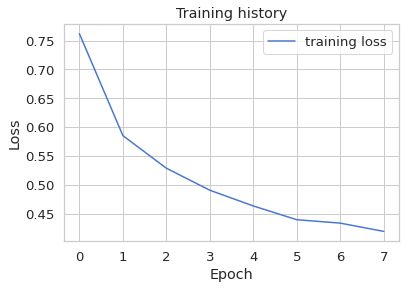

In [ ]:
plt.plot(history['train_loss'], label='training loss')

plt.title('Training history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


## 4.7 Result of the model on Test Set

In [ ]:
test_acc, _ = eval_model(
  model,
  test_dataLoader,
  device,
  len(dataframe_test)
)

test_acc.item()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

0.8312841530054644

#5. Sentiment Analysis of New Data

In [ ]:
def predict(text):
  
  encoded_review = tokenizer.encode_plus(
  text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  return_attention_mask=True,
  return_tensors='pt',
  padding = 'longest',
  truncation = True
  )

  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output[0], dim=1)

  class_names = ['negative', 'neutral', 'positive']

  print(f'Review text: {text}')
  print(f'Sentiment  : {class_names[prediction]}')

In [ ]:
predict("I love you")

Review text: I love you
Sentiment  : positive
